<a href="https://colab.research.google.com/github/AriehAllouche/time-series/blob/main/air_passengers_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importation des packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime

In [ ]:
!pip install -q statsmodels
!pip install -q pmdarima
from pmdarima.datasets import load_airpassengers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00


In [ ]:
airp_df = load_airpassengers(as_series=True)
airp_df.index = pd.date_range(start='01/01/1949', periods=len(airp_df), freq='M')
airp_df.name = 'Air Passenger'


In [ ]:
airp_df.head()

1949-01-31    112.0
1949-02-28    118.0
1949-03-31    132.0
1949-04-30    129.0
1949-05-31    121.0
Freq: M, Name: Air Passenger, dtype: float64

In [ ]:
airp_df.tail()


1960-08-31    606.0
1960-09-30    508.0
1960-10-31    461.0
1960-11-30    390.0
1960-12-31    432.0
Freq: M, Name: Air Passenger, dtype: float64

In [ ]:
airp_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: M
Series name: Air Passenger
Non-Null Count  Dtype  
--------------  -----  
144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [ ]:
airp_df.describe()


count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Air Passenger, dtype: float64

In [ ]:
airp_df.isnull().sum()

0

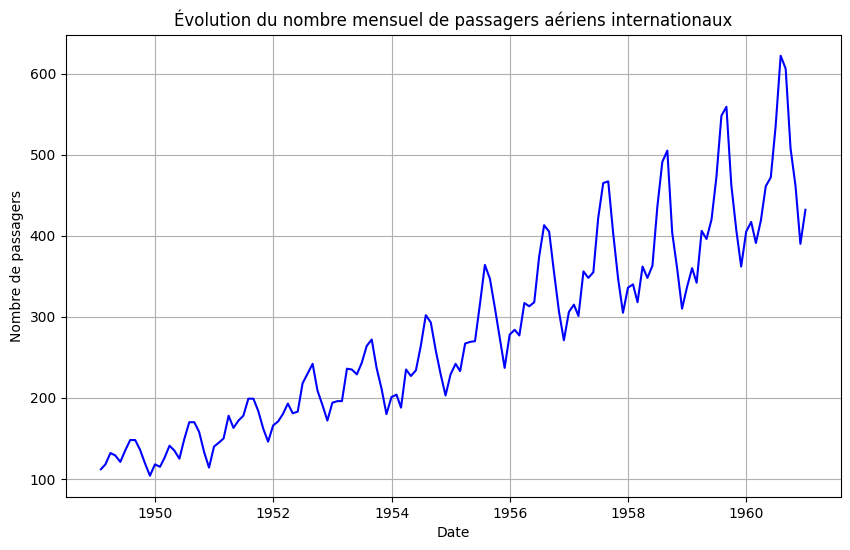

In [ ]:
# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(airp_df, color='blue')
plt.title('Évolution du nombre mensuel de passagers aériens internationaux')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.grid(True)
plt.show()


En examinant attentivement la série temporelle des passagers aériens, plusieurs caractéristiques émergent clairement. Tout d'abord, on peut remarquer une **tendance haussière** marquée, illustrée par une augmentation régulière du nombre de passagers au fil du temps. Cette tendance est révélatrice d'une non-stationnarité, car la moyenne des données évolue continuellement, ce qui contredit l'un des critères fondamentaux de la stationnarité.

En plus de cette tendance, on observe également une **variance non constante** dans la série. La variance, qui mesure la dispersion des données par rapport à leur moyenne, semble augmenter avec le temps, ce qui signifie que la volatilité des données croît également. Cette variation de la variance confirme encore davantage l'absence de stationnarité dans la série.


En résumé, la série temporelle des passagers aériens présente une tendance haussière, une variance croissante et des variations temporelles importantes. Ces caractéristiques convergent toutes vers une conclusion : la série n'est pas stationnaire et nécessite des techniques appropriées de modélisation et d'analyse pour en tenir compte efficacement.

En affichant un graphique boxplot mois par mois pour la série temporelle des passagers aériens (airp_df), nous pouvons observer la saisonnalité dans les données. Si la série temporelle présente une saisonnalité, cela se traduira par des modèles récurrents dans la distribution des données d'un mois à l'autre.

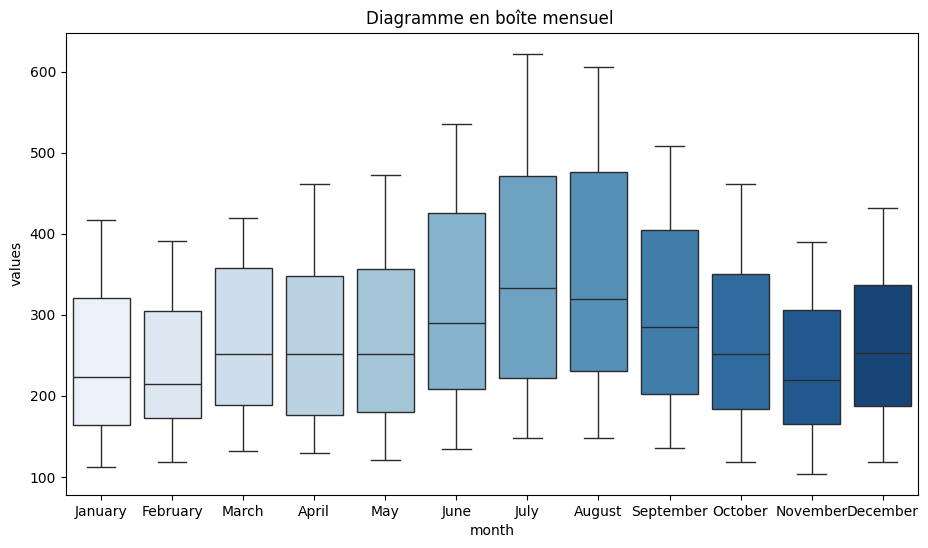

In [ ]:
# Convertir la série temporelle en DataFrame
df = airp_df.to_frame(name='values')
df['month'] = [d.month_name() for d in pd.to_datetime(df.index)]

# Définir un dégradé de couleur bleu
blue_palette = sns.color_palette("Blues", n_colors=12)

# Tracer le boxplot avec dégradé de couleur bleu
plt.figure(figsize=(11,6))
g = sns.boxplot(x='month', y='values', data=df, palette=blue_palette)
g.set_title("Diagramme en boîte mensuel ")
plt.show()


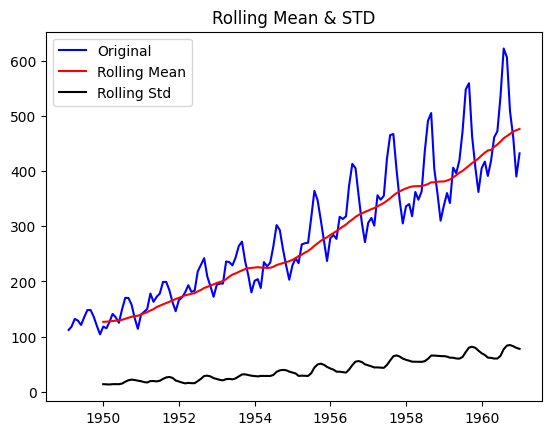

In [ ]:
rolmean = airp_df.rolling(window=12).mean()
rolstd = airp_df.rolling(window=12).std()
orig = plt.plot(airp_df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & STD')
plt.show()

**ACF et PACF**
L'**ACF** (fonction d'autocorrélation) et la **PACF** (fonction d'autocorrélation partielle) sont deux outils fondamentaux dans l'analyse des séries temporelles. Elles permettent de comprendre les relations temporelles dans une série de données.

**ACF** (fonction d'autocorrélation)
L'ACF mesure la corrélation entre une séquence et elle-même à différents moments dans le temps. En d'autres termes, elle évalue la similarité entre les observations en fonction du décalage dans le temps entre elles.

Pour un décalage t, l'ACF mesure la corrélation entre la série temporelle et elle-même décalée de t périodes.

Par exemple, une ACF de 0,9 avec un décalage de 2 signifie que les données sont très similaires à elles-mêmes il y a deux périodes de temps.

**PACF** (fonction d'autocorrélation partielle)
La PACF est une corrélation qui exclut l'effet des termes intermédiaires. Autrement dit, elle mesure la corrélation entre des observations à un intervalle donné, en prenant en compte les valeurs à des intervalles plus courts.

Pour un décalage t, la PACF est la corrélation entre la série temporelle et elle-même décalée de t périodes, tout en soustrayant les effets des décalages de 1 à t-1.

Par exemple, une PACF de 0,5 avec un décalage de 3 signifie que les données sont moyennement similaires à elles-mêmes il y a trois périodes de temps, après avoir pris en compte les décalages de 1 et 2.

**Utilisations**
Les graphiques ACF et PACF sont largement utilisés pour aider à déterminer les paramètres d'un modèle ARIMA en analyse des séries temporelles. Par exemple, le graphique ACF peut aider à identifier le terme MA (moyenne mobile) du modèle, tandis que le graphique PACF peut aider à identifier le terme AR (auto-régressif).

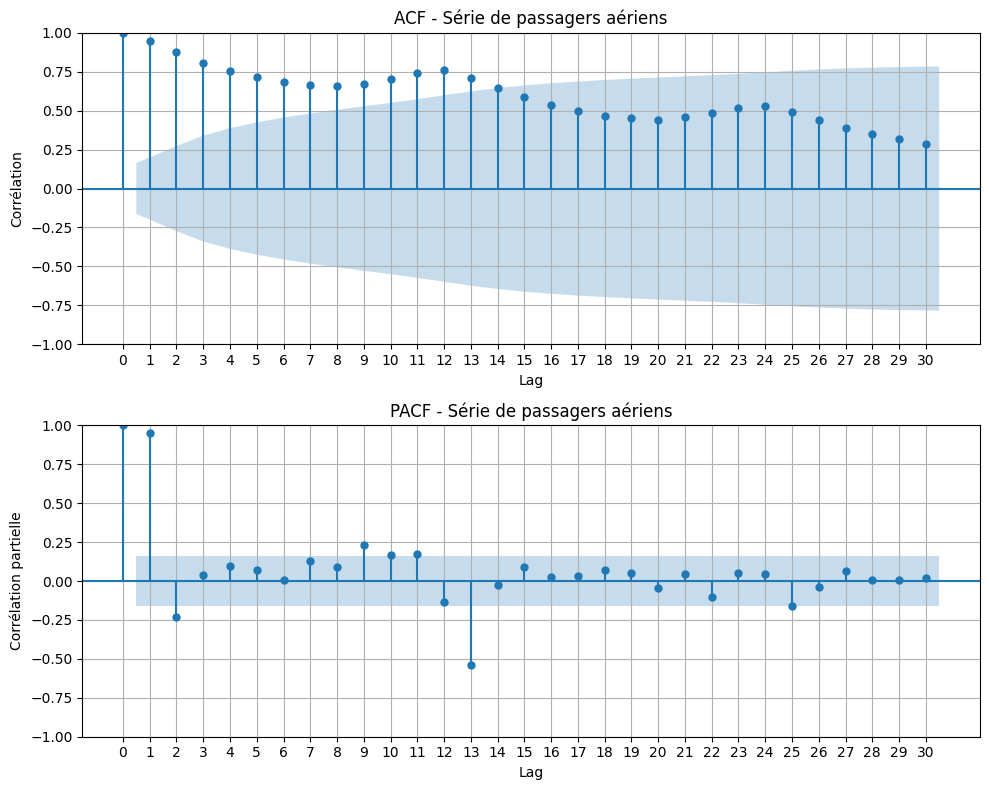

In [ ]:
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(airp_df, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - Série de passagers aériens')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(airp_df, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - Série de passagers aériens')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

Lorsque l'ACF présente une décroissance lente, cela indique une tendance persistante dans les données, ce qui suggère que la série n'est pas stationnaire.

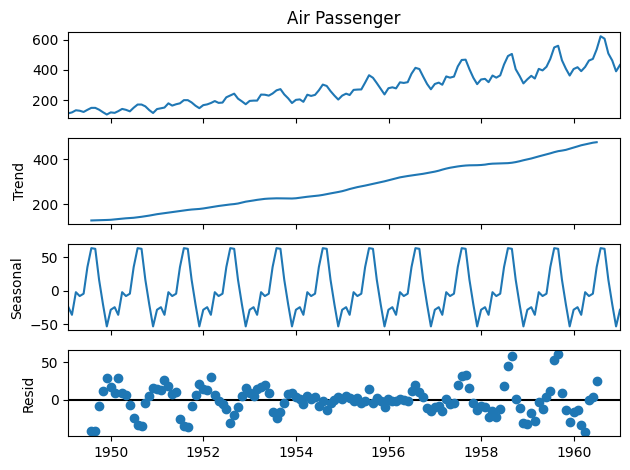

In [ ]:
tsa = seasonal_decompose(airp_df, period=12)
# Affichage des composantes individuelles
tsa.plot()
plt.show()

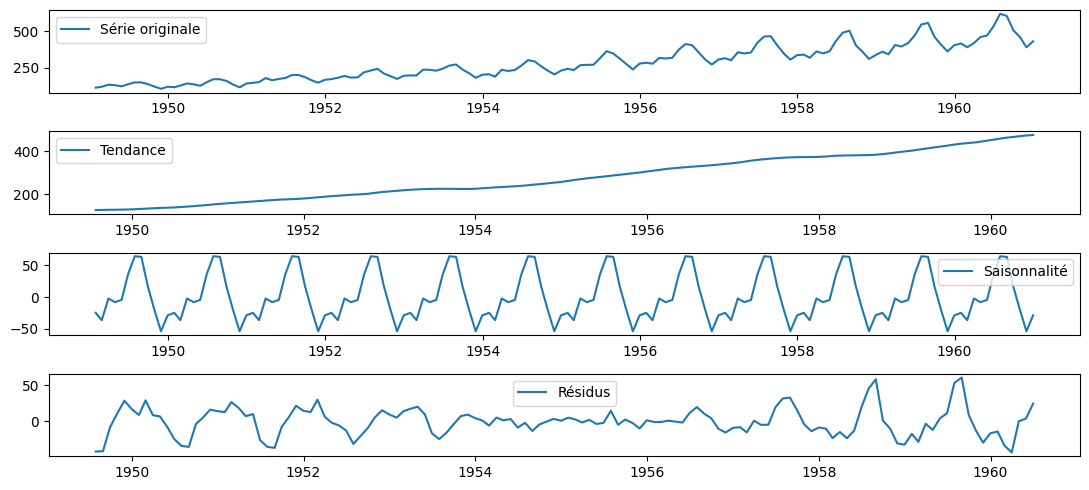

In [ ]:
# Effectuer la décomposition saisonnière
decomposition = seasonal_decompose(airp_df,period=12)

# Extraire les composantes de la décomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Afficher les composantes de la décomposition
plt.figure(figsize=(11, 5))

plt.subplot(411)
plt.plot(airp_df, label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

En résumé, l'examen des résidus révèle une hétéroscédasticité, ce qui signifie des variations non constantes dans les résidus du modèle. Cela suggère que le modèle additif considéré pourrait ne pas saisir pleinement la complexité des relations entre les variables.

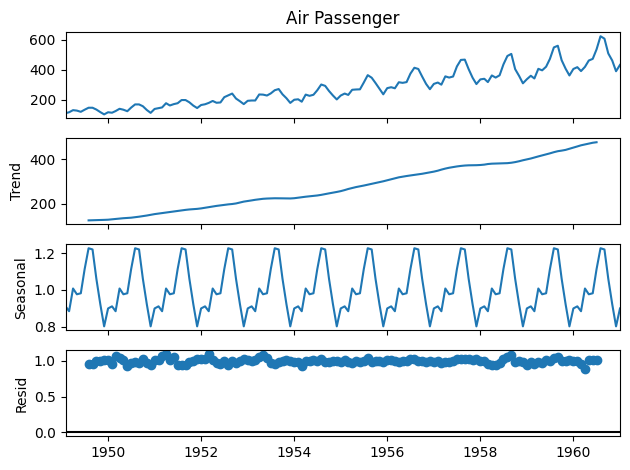

In [ ]:
tsa = seasonal_decompose(airp_df, model='multiplicative',period=12)
# Affichage des composantes individuelles
tsa.plot()
plt.show()

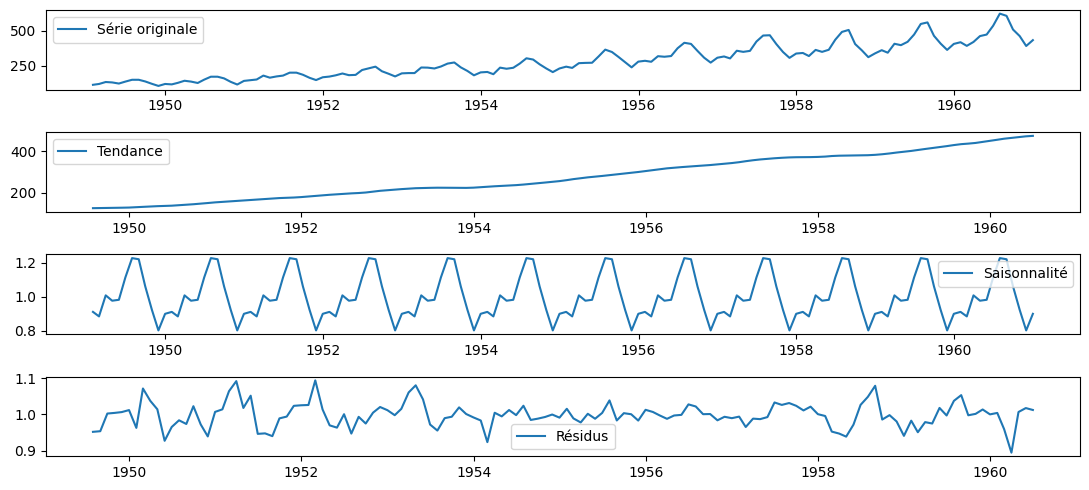

In [ ]:
# Effectuer la décomposition saisonnière
decomposition = seasonal_decompose(airp_df, model='multiplicative',period=12)

# Extraire les composantes de la décomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Afficher les composantes de la décomposition
plt.figure(figsize=(11, 5))

plt.subplot(411)
plt.plot(airp_df, label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Résidu autour de 1 donc on peut considerer que c'est un modéle multplicatif

In [ ]:
# Analyse de la stationnarité de la variable
# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(airp_df)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | 0.8153688792060498            |
| P-valeur       | 0.991880243437641             |
| Conclusion     | La série est non stationnaire |


Le test de Dickey-Fuller nous prouve que la séries n'est pas stationnaire

In [ ]:
def compute_kpss(df, **kwargs):
    kpss_result = kpss(df, **kwargs)

    if kpss_result[1] < 0.05:
        conclusion = 'La série est non stationnaire'
    else:
        conclusion = 'La série est stationnaire'

    results = {'Test Statistic': kpss_result[0],
               'p-value': kpss_result[1],
               'Lags Used': kpss_result[2],
               'Critical Values': kpss_result[3],
               'Conclusion': conclusion}

    return pd.Series(results, name=df.name)

kpss_tests = compute_kpss(df=airp_df)

# Formater les résultats dans un tableau
table = [
    ['Test Statistic', kpss_tests['Test Statistic']],
    ['p-value', kpss_tests['p-value']],
    ['Lags Used', kpss_tests['Lags Used']],
    ['Critical Values', kpss_tests['Critical Values']],
    ['Conclusion', kpss_tests['Conclusion']]
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))


| Métrique        | Valeur                                                  |
|-----------------|---------------------------------------------------------|
| Test Statistic  | 1.6513122354165206                                      |
| p-value         | 0.01                                                    |
| Lags Used       | 8                                                       |
| Critical Values | {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739} |
| Conclusion      | La série est non stationnaire                           |


<ipython-input-20-f4f8ccb36a29>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df, **kwargs)


**texte en gras**

Dans le contexte des tests de stationnarité :



1.  Test ADF (Dickey-Fuller augmenté) :
  

**Le test ADF** est conçu pour détecter la présence de racines unitaires(une racine unitaire dans une série temporelle indique qu'elle ne revient pas à son niveau moyen après une perturbation, mais qu'elle continue à dériver dans une direction spécifique.
Formellement, une série temporelle possède une racine unitaire si elle ne converge pas vers une moyenne constante à mesure que le temps avance. Cela peut se manifester par une tendance à la hausse ou à la baisse qui ne se stabilise pas.)
dans une série temporelle. Si la p-value du test est inférieure à unseuil (généralement 0,05), on rejette l'hypothèse nulle selon laquelle la série possède une racine unitaire, ce qui suggère que la série est stationnaire.
En d'autres termes, si le test ADF conclut que la série est stationnaire, cela signifie que la série revient à son niveau moyen après une perturbation, ce qui implique l'absence de racines unitaires.

2. Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin) :

**Le test KPSS** examine si la variance de la série est constante à travers le temps. Si la p-value du test est inférieure à un seuil (généralement 0,05), on rejette l'hypothèse nulle selon laquelle la série est stationnaire.
Contrairement au test ADF qui se concentre sur les tendances dans la moyenne, le test KPSS se concentre sur les variations de variance dans la série temporelle pour évaluer la stationnarité.


En conclusion notre séries est non stationnaire et multiplicatif

On va rendre notre modéle additif en passant par le log

In [ ]:
# Appliquer la transformation logarithmique à la série RETAIL SALES
airp_df = np.log(airp_df)
# Vérifier les premières lignes de la série transformée
airp_df.head()

1949-01-31    4.718499
1949-02-28    4.770685
1949-03-31    4.882802
1949-04-30    4.859812
1949-05-31    4.795791
Freq: M, Name: Air Passenger, dtype: float64

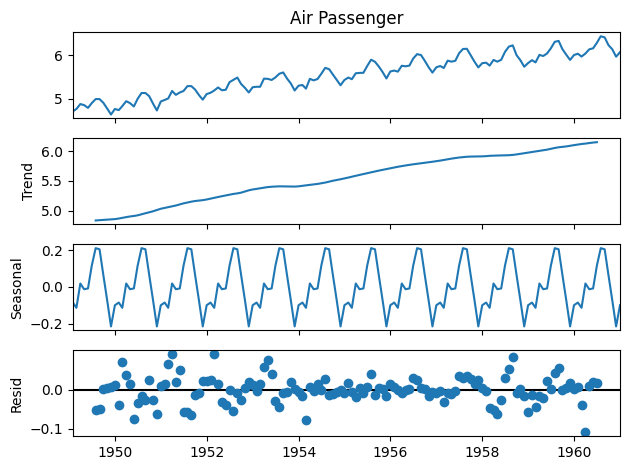

In [ ]:
tsa = seasonal_decompose(airp_df, period=12)
# Affichage des composantes individuelles
tsa.plot()
plt.show()

Dans les residus variance assez faible

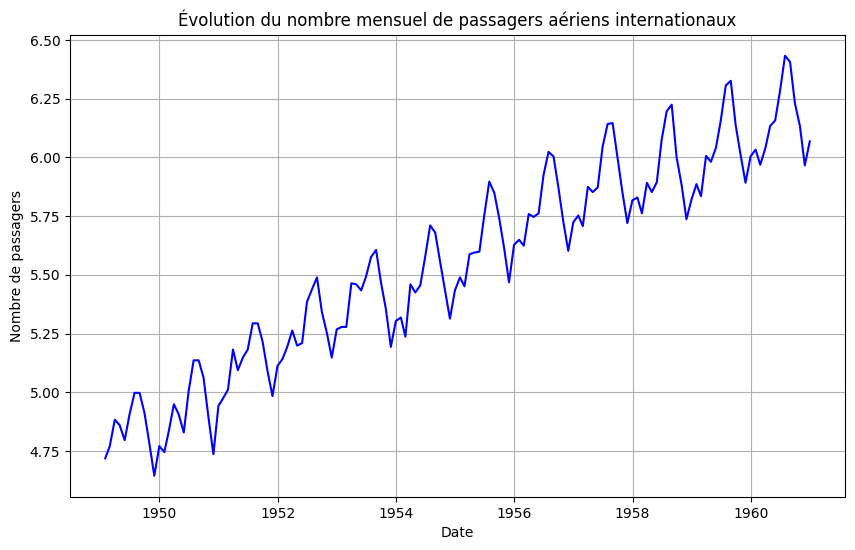

In [ ]:
# Créer le graphique avec log
plt.figure(figsize=(10, 6))
plt.plot(airp_df, color='blue')
plt.title('Évolution du nombre mensuel de passagers aériens internationaux')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.grid(True)
plt.show()

On observe que l'amplitude a disparus

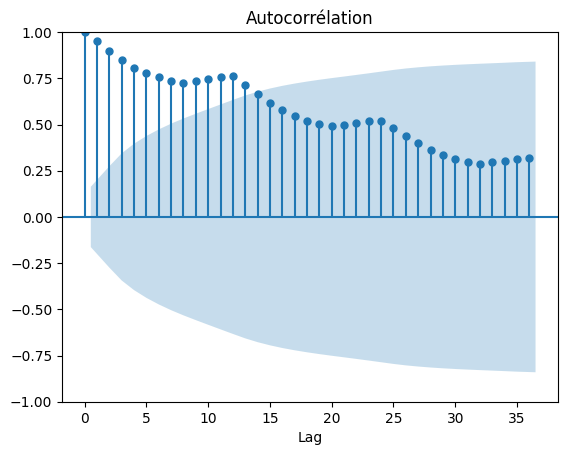

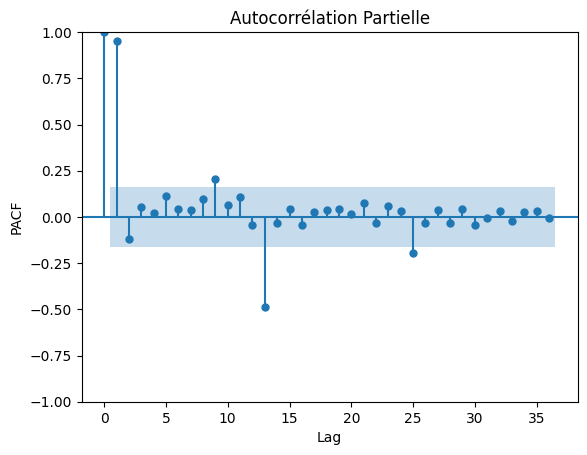

In [ ]:
# Tracer l'autocorrélation
plot_acf(airp_df, lags=36)
plt.title('Autocorrélation')
plt.xlabel('Lag')
plt.show()


# Tracer l'autocorrélation partielle avec un maximum de 12 lags
plot_pacf(airp_df, lags=36)
plt.title('Autocorrélation Partielle')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

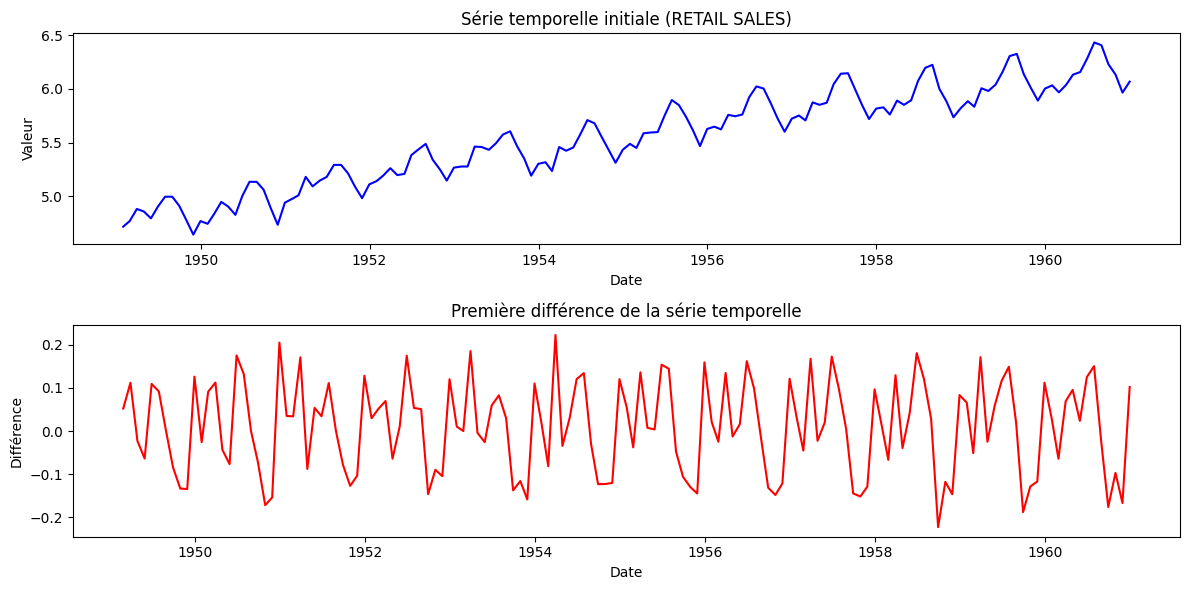

In [ ]:
time_series =airp_df
# Calculer la première différence
first_difference = time_series.diff().dropna()

# Affichage de la série temporelle initiale et de la première différence en graphique
plt.figure(figsize=(12, 6))

# Série temporelle initiale
plt.subplot(2, 1, 1)
plt.plot(time_series, color='blue')
plt.title('Série temporelle initiale (RETAIL SALES)')
plt.xlabel('Date')
plt.ylabel('Valeur')

# Première différence
plt.subplot(2, 1, 2)
plt.plot(first_difference, color='red')
plt.title('Première différence de la série temporelle')
plt.xlabel('Date')
plt.ylabel('Différence')

plt.tight_layout()
plt.show()

<Figure size 2000x700 with 0 Axes>

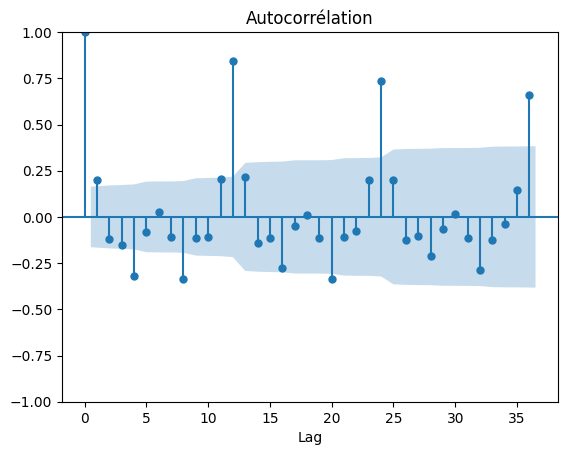

<Figure size 2000x700 with 0 Axes>

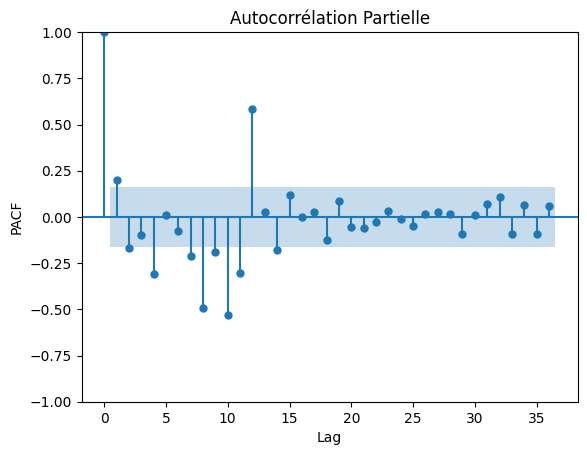

In [ ]:
# Tracer l'autocorrélation de la série
plt.figure(figsize=(20, 7))
plot_acf(first_difference, lags=36)
plt.title('Autocorrélation')
plt.xlabel('Lag')
plt.show()

# Tracer l'autocorrélation partielle avec un maximum de 12 lags
plt.figure(figsize=(20, 7))
plot_pacf(first_difference, lags=36)
plt.title('Autocorrélation Partielle')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

pic saisonnier qu'on identifie avec une peridiocité de 12.

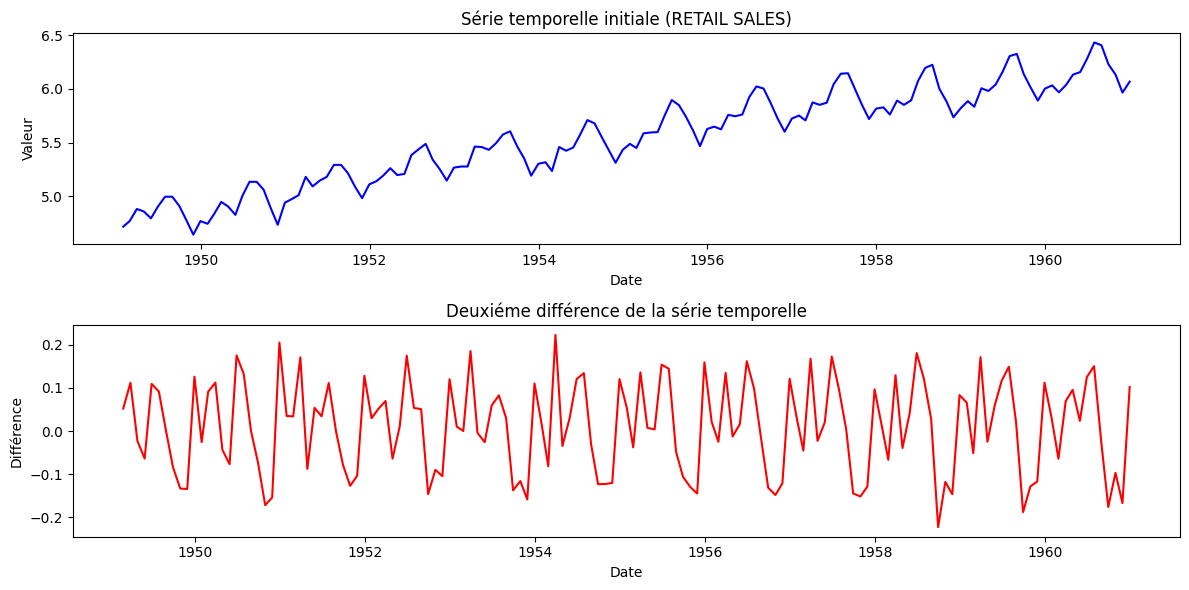

In [ ]:
# Calculer la première différence
second_difference = time_series.diff().diff(12)

# Affichage de la série temporelle initiale et de la première différence en graphique
plt.figure(figsize=(12, 6))

# Série temporelle initiale
plt.subplot(2, 1, 1)
plt.plot(time_series, color='blue')
plt.title('Série temporelle initiale (RETAIL SALES)')
plt.xlabel('Date')
plt.ylabel('Valeur')

# Première différence
plt.subplot(2, 1, 2)
plt.plot(first_difference, color='red')
plt.title('Deuxiéme différence de la série temporelle')
plt.xlabel('Date')
plt.ylabel('Différence')

plt.tight_layout()
plt.show()

<Figure size 2000x700 with 0 Axes>

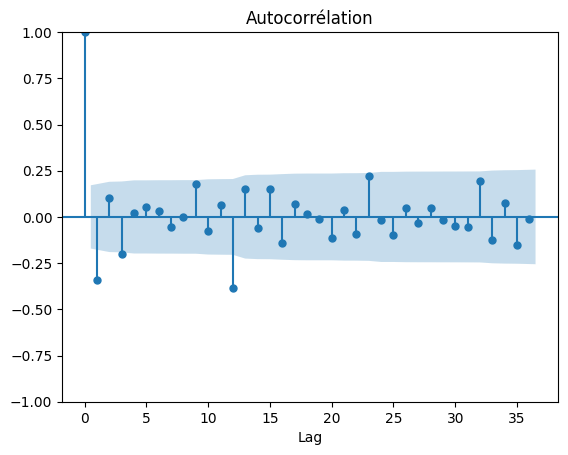

<Figure size 2000x700 with 0 Axes>

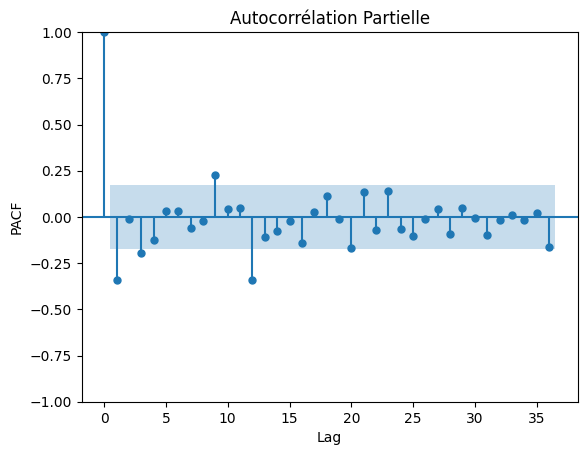

In [ ]:
# Tracer l'autocorrélation de la série
plt.figure(figsize=(20, 7))
plot_acf(second_difference.dropna(), lags=36)
plt.title('Autocorrélation')
plt.xlabel('Lag')
plt.show()

# Tracer l'autocorrélation partielle avec un maximum de 12 lags
plt.figure(figsize=(20, 7))
plot_pacf(second_difference.dropna(), lags=36)
plt.title('Autocorrélation Partielle')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

De maniére globale on peut dire qu'on a tendance a tendre vers 0 sur le graphique de acf et pacf malgres des pics de saisonalité

In [ ]:
# Analyse de la stationnarité de la variable
# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(second_difference.dropna())

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -4.4433249418311425       |
| P-valeur       | 0.00024859123113838495    |
| Conclusion     | La série est stationnaire |


On a rendu notre séries stationnaire

On va essayer un modéle arma avec paramétre p=1 et q=1

In [ ]:
import statsmodels.api as sm
model = sm.tsa.SARIMAX(airp_df, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima = model.fit()
print(sarima.summary())


                                     SARIMAX Results                                      
Dep. Variable:                      Air Passenger   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.946
Date:                            Thu, 11 Apr 2024   AIC                           -481.893
Time:                                    13:11:57   BIC                           -470.392
Sample:                                01-31-1949   HQIC                          -477.220
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1965      0.199      0.987      0.323      -0.194       0.587
ma.L1         -0.5788      0.171   

In [ ]:
model = sm.tsa.SARIMAX(airp_df, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima = model.fit()
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Air Passenger   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Thu, 11 Apr 2024   AIC                           -483.393
Time:                                    13:12:00   BIC                           -474.767
Sample:                                01-31-1949   HQIC                          -479.888
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.502      0.000      -0.545      -0.259
ma.S.L12      -0.5569      0.096   

**Performance du modèle **: Le modèle SARIMA semble bien s'adapter aux données, comme en témoigne le log-vraisemblance élevé (465.495). De plus, les critères d'information tels que l'AIC et le BIC sont négatifs, ce qui indique une bonne adéquation du modèle aux données.

**Paramètres du modèle**: Le modèle SARIMA est spécifié comme SARIMA(0, 1, 1)x(0, 1, 1, 12), ce qui signifie qu'il inclut un terme de moyenne mobile d'ordre 1 et un terme de moyenne mobile saisonnier d'ordre 1, avec une période saisonnière de 12 mois.

**Coefficients** : Les coefficients estimés pour les termes de moyenne mobile sont tous significatifs (p < 0.05), ce qui suggère qu'ils contribuent de manière significative à la modélisation de la série temporelle.

**Hétéroscédasticité** : Le test d'hétéroscédasticité (H) montre une valeur p significative (p < 0.05), indiquant que les résidus du modèle présentent des variations non constantes dans la variance. Cela suggère qu'il pourrait y avoir des aspects non capturés par le modèle, ce qui nécessite une évaluation plus approfondie.

**Autres tests de diagnostic** : Les tests de Ljung-Box et de Jarque-Bera sont utilisés pour évaluer la corrélation sérielle des résidus et la normalité des résidus, respectivement. Un faible Q (Ljung-Box) et un p-value élevé indiquent une bonne adéquation du modèle, tandis qu'un p-value plus faible dans le test de Jarque-Bera suggère une légère asymétrie ou une légère non-normalité dans les résidus.

In [ ]:
# Convertir la série à l'exponentielle
airp_df = np.exp(airp_df)

# Afficher les premières lignes pour vérification
print(airp_df.head())


1949-01-31    112.0
1949-02-28    118.0
1949-03-31    132.0
1949-04-30    129.0
1949-05-31    121.0
Freq: M, Name: Air Passenger, dtype: float64


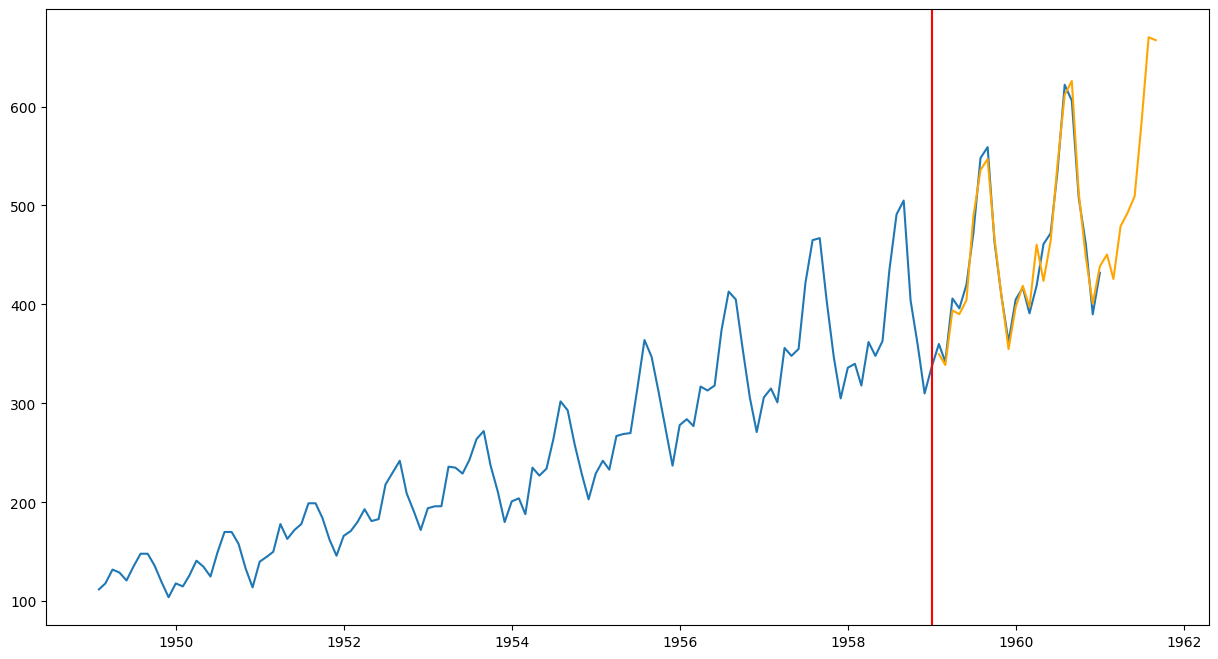

In [ ]:
plt.figure(figsize=(15, 8))
pred = np.exp(sarima.predict(120,151))
plt.plot(airp_df)
plt.plot(pred, color='orange')
plt.axvline(x=datetime.date(1959, 1, 1), color='red')
plt.show()

In [ ]:
true = airp_df[120:133].values
pred = np.exp(sarima.predict(120, 132))  # Ajuster la plage des prédictions
err = pred.values - true
np.mean(err) / np.mean(true) * 100

-1.149765794677662

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
true = airp_df[120:133].values
pred = np.exp(sarima.predict(120, 132))
err = pred - true

# Calculer les performances
mae = mean_absolute_error(true, pred)
mse = mean_squared_error(true, pred)
rmse = np.sqrt(mse)
r2 = r2_score(true, pred)
# Afficher les performances
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Valeur': [mae, mse, rmse, r2]
})
print(performance_df)

  Métrique     Valeur
0      MAE   8.304434
1      MSE  95.718656
2     RMSE   9.783591
3       R²   0.976853


Dans l'ensemble, le modèle SARIMA ajusté présente de bonnes performances pour la prédiction des passagers aériens, avec des métriques telles que l'erreur moyenne absolue (MAE) de 8.30, l'erreur quadratique moyenne (MSE) de 95.72, la racine carrée de l'erreur quadratique moyenne (RMSE) de 9.78, et un coefficient de détermination (R²) élevé de 0.98, indiquant une forte capacité du modèle à expliquer la variance des données.De plus, en ajustant la plage des prédictions, une légère sous-estimation d'environ -1.15% par rapport à la moyenne des valeurs réelles est observée, indiquant une tendance à la baisse dans les prévisions de passagers.